In [ ]:
#default_exp learner
from nbdev.showdoc import show_doc

# Ensemble Learner

> Implements functions necessary to build an  `EnsembleLearner` suitable for bioimgage segmentation

In [ ]:
#hide
import imageio
from scipy import ndimage
from fastcore.test import *

In [ ]:
#export
import shutil, gc, joblib, json, zarr, numpy as np, pandas as pd
import time
import tifffile, cv2
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader 
from dataclasses import dataclass, field, asdict
from pathlib import Path

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter
from skimage.color import label2rgb
import matplotlib.pyplot as plt

from fastprogress import progress_bar
from fastcore.basics import patch, GetAttr
from fastcore.foundation import add_docs, L
from fastai import optimizer
from fastai.torch_core import TensorImage
from fastai.learner import Learner
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.progress import CSVLogger
from fastai.data.core import DataLoaders
from fastai.data.transforms import get_image_files, get_files
from fastai.vision.augment import Brightness, Contrast, Saturation
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import Dice, DiceMulti

from deepflash2.losses import get_loss
from deepflash2.models import create_smp_model, save_smp_model, load_smp_model, run_cellpose
from deepflash2.data import TileDataset, RandomTileDataset, _read_img, _read_msk
from deepflash2.utils import dice_score, plot_results, get_label_fn, calc_iterations, save_mask, save_unc, export_roi_set, get_instance_segmentation_metrics
from deepflash2.utils import compose_albumentations as _compose_albumentations
import deepflash2.tta as tta

## Config

In [ ]:
#export
@dataclass
class Config:
    "Config class for settings."

    # Project
    project_dir:str = '.'

    # GT Estimation Settings
    staple_thres:float = 0.5
    staple_fval:int= 1
    majority_vote_undec:int = 1

    # Train General Settings
    n_models:int = 5
    max_splits:int=5
    random_state:int = 42
        
    # Pytorch Segmentation Model Settings
    arch:str = 'Unet'
    encoder_name:str = 'resnet34'
    encoder_weights:str = 'imagenet'

    # Train Data Settings
    n_classes:int = 2
    tile_shape:int = 512
    instance_labels:bool = False

    # Train Settings
    base_lr:float = 0.001
    batch_size:int = 4
    weight_decay:float = 0.001
    mixed_precision_training:bool = False
    optim:str = 'Adam'
    loss:str = 'CrossEntropyDiceLoss'
    n_iter:int = 2500
    sample_mult:int = 0

    # Validation and Prediction Settings
    tta:bool = True
    border_padding_factor:float = 0.25
    shift:float = 0.5

    # Train Data Augmentation
    gamma_limit_lower:int = 80
    gamma_limit_upper:int = 120
    CLAHE_clip_limit:float = 0.0
    brightness_limit:float = 0.0
    contrast_limit:float = 0.0
    flip:bool = True
    rot:int = 360
    distort_limit:float = 0
        
    # Loss Settings
    mode:str = 'multiclass' #currently only tested for multiclass
    loss_alpha:float = 0.5 # Twerksky/Focal loss
    loss_beta:float = 0.5 # Twerksy Loss
    loss_gamma:float = 2.0 # Focal loss
    loss_smooth_factor:float = 0. #SoftCrossEntropyLoss
    
    # Pred Settings
    pred_tta:bool = True
    min_pixel_export:int = 0
        
    # Instance Segmentation Settings
    cellpose_model:str='nuclei'
    cellpose_diameter:int=0
    cellpose_export_class:int=1
    instance_segmentation_metrics:bool=False

    # Folder Structure
    gt_dir:str = 'GT_Estimation'
    train_dir:str = 'Training'
    pred_dir:str = 'Prediction'
    ens_dir:str = 'models'
    val_dir:str = 'valid'
    
    @property
    def albumentation_kwargs(self):
        kwargs = ['gamma_limit_lower', 'gamma_limit_upper', 'CLAHE_clip_limit', 
                  'brightness_limit', 'contrast_limit', 'distort_limit']
        return dict(filter(lambda x: x[0] in kwargs, self.__dict__.items()))

    @property
    def svm_kwargs(self):
        svm_vars = ['kernel', 'nu', 'gamma']
        return dict(filter(lambda x: x[0] in svm_vars, self.__dict__.items()))

    def save(self, path):
        'Save configuration to path'
        path = Path(path).with_suffix('.json')
        with open(path, 'w') as config_file:
            json.dump(asdict(self), config_file)
        print(f'Saved current configuration to {path}.json')
        return path

    def load(self, path):
        'Load configuration from path'
        path = Path(path)
        try:
            with open(path) as config_file: c = json.load(config_file)
            if not Path(c['project_dir']).is_dir(): c['project_dir']='deepflash2'
            for k,v in c.items(): setattr(self, k, v)
            print(f'Successsfully loaded configuration from {path}')
        except:
            print('Error! Select valid config file (.json)')

In [ ]:
t1 = Config(n_models=3)
path = t1.save('test_config')
t2 = Config()
t2.load(path)
test_eq(t1, t2)
path.unlink()

Saved current configuration to test_config.json.json
Successsfully loaded configuration from test_config.json


In [ ]:
#export
_optim_dict = {
    'ranger' : optimizer.ranger,
    'Adam' : optimizer.Adam,
    'RAdam' : optimizer.RAdam,
    'QHAdam' :optimizer.QHAdam,
    'Larc' : optimizer.Larc,
    'Lamb' : optimizer.Lamb,
    'SGD' : optimizer.SGD,
    'RMSProp' : optimizer.RMSProp,
}

## Ensemble Prediction Class

In [ ]:
#export
# from https://github.com/MIC-DKFZ/nnUNet/blob/2fade8f32607220f8598544f0d5b5e5fa73768e5/nnunet/network_architecture/neural_network.py#L250
def _get_gaussian(patch_size, sigma_scale=1. / 8) -> np.ndarray:
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode='constant', cval=0)
    gaussian_importance_map = gaussian_importance_map / np.max(gaussian_importance_map) * 1
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0])

    return gaussian_importance_map

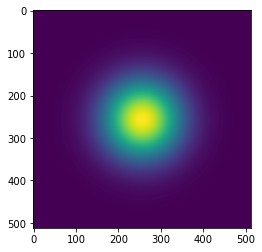

In [ ]:
plt.imshow(_get_gaussian((512,512)));

In [ ]:
#export
def energy_score(x, T=1, dim=1):
    'Return the energy score as proposed by  Liu, Weitang, et al. (2020).'
    return -(T*torch.logsumexp(x/T, dim=dim))

In [ ]:
#export
class EnsemblePredict():
    'Class for prediction with multiple models'
    def __init__(self, models_paths, zarr_store=None):
        self.models_paths = models_paths
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.init_models()
        
        # Init zarr storage
        self.store = str(zarr_store) if zarr_store else zarr.storage.TempStore()
        self.root = zarr.group(store=self.store)
        self.g_smx = self.root.require_group('smx')
        self.g_eng, self.g_std = None, None
        
    def init_models(self):
        self.models = []
        self.stats = None
        for p in self.models_paths:     
            model, stats = load_smp_model(p)
            if not self.stats: self.stats = stats
            assert np.array_equal(stats, self.stats), 'Only models trained on the same stats are allowed.'
            model.float()
            model.eval()
            model.to(self.device)
            self.models.append(model)
            
    def predict(self, 
                ds, 
                use_tta=True, 
                bs=4, 
                use_gaussian=True, 
                sigma_scale=1./8, 
                uncertainty_estimates=True, 
                uncertainty_type = 'uncertainty',
                energy_scores=False, 
                energy_T = 1., 
                verbose=0):
        
        if verbose>0: print('Ensemble prediction with models:', self.models_paths)
            
        tfms = [tta.HorizontalFlip(),tta.VerticalFlip()] if use_tta else []
        if verbose>0: print('Using Test-Time Augmentation with:', tfms)
                      
        dl = DataLoader(ds, bs, num_workers=0, shuffle=False, pin_memory=True)

        # Create zero arrays
        data_shape = ds.image_shapes[0]
        softmax = np.zeros((*data_shape, ds.c), dtype='float32')
        merge_map = np.zeros(data_shape, dtype='float32')
        stdeviation = np.zeros(data_shape, dtype='float32') if uncertainty_estimates else None
        energy = np.zeros(data_shape, dtype='float32') if energy_scores else None

        # Define merge weights
        if use_gaussian:
            mw_numpy = _get_gaussian(ds.output_shape, sigma_scale)
        else: 
            mw_numpy = np.ones(dl.output_shape)
        mw = torch.from_numpy(mw_numpy).to(self.device)
        
        # Loop over tiles (indices required!)
        for tiles, idxs in iter(dl):
            tiles = tiles.to(self.device)
            smx_merger = tta.Merger()
            if energy_scores: 
                energy_merger = tta.Merger()
            
            # Loop over tt-augmentations
            for t in tta.Compose(tfms): 
                aug_tiles = t.augment_image(tiles)
                model_merger = tta.Merger()
                if energy_scores: engergy_list = []
                
                # Loop over models
                for model in self.models:
                    with torch.inference_mode(): 
                        logits = model(aug_tiles)
                    logits = t.deaugment_mask(logits)
                    smx_merger.append(F.softmax(logits, dim=1)) 
                    if energy_scores: 
                        energy_merger.append(-energy_score(logits, energy_T)) #negative energy score

            out_list = []
            # Apply gaussian weigthing
            batch_smx = smx_merger.result()*mw.view(1,1,*mw.shape)
            # Reshape and append to list
            out_list.append([x for x in batch_smx.permute(0,2,3,1).cpu().numpy()])
            
            if uncertainty_estimates:
                batch_std = torch.mean(smx_merger.result(uncertainty_type), dim=1)*mw.view(1,*mw.shape)
                out_list.append([x for x in batch_std.cpu().numpy()])
            
            if energy_scores:
                batch_energy =  energy_merger.result()*mw.view(1,*mw.shape)
                out_list.append([x for x in batch_energy.cpu().numpy()])

            # Compose predictions
            for preds in zip(*out_list, idxs):
                if len(preds)==4: smx,std,eng,idx = preds 
                elif uncertainty_estimates: smx,std,idx = preds 
                elif energy_scores: smx,eng,idx = preds 
                
                else: smx, idx = preds
                out_slice = ds.out_slices[idx]
                in_slice = ds.in_slices[idx]
                softmax[out_slice] += smx[in_slice]
                merge_map[out_slice] += mw_numpy[in_slice]
                
                if uncertainty_estimates:
                    stdeviation[out_slice] += std[in_slice]
                if energy_scores:
                    energy[out_slice] += eng[in_slice]
                    
        # Normalize weighting           
        softmax /= merge_map[..., np.newaxis]
        if uncertainty_estimates:
            stdeviation /= merge_map   
        if energy_scores:
            energy /= merge_map

        return softmax, stdeviation, energy
    
    def predict_images(self, image_list, ds_kwargs={}, verbose=1, **kwargs):
        "Predict images in 'image_list' with kwargs and save to zarr"
    
        for f in progress_bar(image_list, leave=False):
            if verbose>0: print(f'Predicting {f.name}')
            ds = TileDataset([f], stats=self.stats, return_index=True, **ds_kwargs)
            softmax, stdeviation, energy = self.predict(ds, **kwargs)
            
            # Save to zarr
            self.g_smx[f.name] = softmax
            if stdeviation is not None: 
                self.g_std = self.root.require_group('std')
                self.g_std[f.name] = stdeviation
            if energy is not None: 
                self.g_eng = self.root.require_group('energy')
                self.g_eng[f.name] = energy
        
        return self.g_smx, self.g_std, self.g_eng       

## Ensemble Learner

In [ ]:
#export
class EnsembleLearner(GetAttr):
    _default = 'config' 
    def __init__(self, image_dir='images', mask_dir=None, config=None, path=None, ensemble_path=None, preproc_dir=None, 
                 label_fn=None, metrics=None, cbs=None, ds_kwargs={}, dl_kwargs={}, model_kwargs={}, stats=None, files=None):

        self.config = config or Config()
        self.stats = stats
        self.dl_kwargs = dl_kwargs
        self.model_kwargs = model_kwargs
        self.add_ds_kwargs = ds_kwargs
        self.path = Path(path) if path is not None else Path('.')
        default_metrics = [Dice()] if self.n_classes==2 else [DiceMulti()]
        self.metrics = metrics or default_metrics
        self.loss_fn = self.get_loss()
        self.cbs = cbs or [SaveModelCallback(monitor='dice' if self.n_classes==2 else 'dice_multi')] #ShowGraphCallback
        self.ensemble_dir = ensemble_path or self.path/self.ens_dir
        if ensemble_path is not None: 
            ensemble_path.mkdir(exist_ok=True, parents=True)
            self.load_ensemble(path=ensemble_path)
        else: self.models = {}
        
        self.files = L(files) or get_image_files(self.path/image_dir, recurse=False)
        assert len(self.files)>0, f'Found {len(self.files)} images in "{image_dir}". Please check your images and image folder'
        if any([mask_dir, label_fn]):
            if label_fn: self.label_fn = label_fn
            else: self.label_fn = get_label_fn(self.files[0], self.path/mask_dir)
            #Check if corresponding masks exist
            mask_check = [self.label_fn(x).exists() for x in self.files]
            chk_str = f'Found {len(self.files)} images in "{image_dir}" and {sum(mask_check)} masks in "{mask_dir}".'
            assert len(self.files)==sum(mask_check) and len(self.files)>0, f'Please check your images and masks (and folders). {chk_str}'
            print(chk_str)
                  
        else:
            self.label_fn = label_fn
        self.n_splits=min(len(self.files), self.max_splits)
        self._set_splits()
        self.ds = RandomTileDataset(self.files, label_fn=self.label_fn, 
                                    preproc_dir=preproc_dir,
                                    instance_labels=self.instance_labels,
                                    n_classes=self.n_classes, 
                                    stats=self.stats, 
                                    normalize = True,
                                    sample_mult=self.sample_mult if self.sample_mult>0 else None, 
                                    verbose=0,
                                    **self.add_ds_kwargs)
        
        self.stats = self.ds.stats
        self.in_channels = self.ds.get_data(max_n=1)[0].shape[-1]
        self.df_val, self.df_ens, self.df_model, self.ood = None,None,None,None
        self.recorder = {}
               
    def _set_splits(self):
        if self.n_splits>1:
            kf = KFold(self.n_splits, shuffle=True, random_state=self.random_state)
            self.splits = {key:(self.files[idx[0]], self.files[idx[1]]) for key, idx in zip(range(1,self.n_splits+1), kf.split(self.files))}    
        else:
            self.splits = {1: (self.files[0], self.files[0])}
            
    def _compose_albumentations(self, **kwargs):
        return _compose_albumentations(**kwargs)
        
    @property        
    def pred_ds_kwargs(self):
        # Setting default shapes and padding
        ds_kwargs = self.add_ds_kwargs.copy()
        ds_kwargs['use_preprocessed_labels']= True
        ds_kwargs['preproc_dir']=self.ds.preproc_dir
        ds_kwargs['instance_labels']= self.instance_labels
        ds_kwargs['tile_shape']= (self.tile_shape,)*2
        ds_kwargs['n_classes']= self.n_classes
        ds_kwargs['shift']= self.shift
        ds_kwargs['border_padding_factor']= self.border_padding_factor
        return ds_kwargs
    
    @property        
    def train_ds_kwargs(self):
        # Setting default shapes and padding
        ds_kwargs = self.add_ds_kwargs.copy()
        # Settings from config
        ds_kwargs['use_preprocessed_labels']= True
        ds_kwargs['preproc_dir']=self.ds.preproc_dir
        ds_kwargs['instance_labels']= self.instance_labels
        ds_kwargs['stats']= self.stats
        ds_kwargs['tile_shape']= (self.tile_shape,)*2
        ds_kwargs['n_classes']= self.n_classes
        ds_kwargs['shift']= 1.
        ds_kwargs['border_padding_factor']= 0.
        ds_kwargs['flip'] = self.flip
        ds_kwargs['albumentations_tfms'] = self._compose_albumentations(**self.albumentation_kwargs)
        ds_kwargs['sample_mult'] = self.sample_mult if self.sample_mult>0 else None
        return ds_kwargs
    
    @property
    def model_name(self):
        return f'{self.arch}_{self.encoder_name}_{self.n_classes}classes'  
                    
    def get_loss(self):
        kwargs = {'mode':self.mode,
                  'classes':[x for x in range(1, self.n_classes)],
                  'smooth_factor': self.loss_smooth_factor,
                  'alpha':self.loss_alpha, 
                  'beta':self.loss_beta, 
                  'gamma':self.loss_gamma}
        return get_loss(self.loss, **kwargs)
    
    
    def _get_dls(self, files, files_val=None):
        ds = []
        ds.append(RandomTileDataset(files, label_fn=self.label_fn, **self.train_ds_kwargs))
        if files_val: 
            ds.append(TileDataset(files_val, label_fn=self.label_fn, **self.train_ds_kwargs))
        else:
            ds.append(ds[0])
        dls = DataLoaders.from_dsets(*ds, bs=self.batch_size, pin_memory=True, **self.dl_kwargs)
        if torch.cuda.is_available(): dls.cuda()
        return dls
    
    def _create_model(self):
        model = create_smp_model(arch=self.arch, 
                                 encoder_name=self.encoder_name, 
                                 encoder_weights=self.encoder_weights, 
                                 in_channels=self.in_channels, 
                                 classes=self.n_classes, 
                                 **self.model_kwargs)
        if torch.cuda.is_available(): model.cuda()
        return model
               
    def fit(self, i, n_iter=None, base_lr=None, **kwargs):
        n_iter = n_iter or self.n_iter
        base_lr = base_lr or self.base_lr
        name = self.ensemble_dir/f'{self.model_name}-fold{i}.pth'
        model = self._create_model()
        files_train, files_val = self.splits[i]
        dls = self._get_dls(files_train, files_val)  
        log_name = f'{name.name}_{time.strftime("%Y%m%d-%H%M%S")}.csv'
        log_dir = self.ensemble_dir/'logs'
        log_dir.mkdir(exist_ok=True, parents=True)
        cbs = self.cbs.append(CSVLogger(fname=log_dir/log_name))
        self.learn = Learner(dls, model, 
                             metrics=self.metrics, 
                             wd=self.weight_decay, 
                             loss_func=self.loss_fn, 
                             opt_func=_optim_dict[self.optim], 
                             cbs=self.cbs)
        self.learn.model_dir = self.ensemble_dir.parent/'.tmp'
        if self.mixed_precision_training: self.learn.to_fp16()
        print(f'Starting training for {name.name}')
        epochs = calc_iterations(n_iter=n_iter,ds_length=len(dls.train_ds), bs=self.batch_size)
        #self.learn.fit_one_cycle(epochs, lr_max)
        self.learn.fine_tune(epochs, base_lr=base_lr)

        print(f'Saving model at {name}')
        name.parent.mkdir(exist_ok=True, parents=True)
        save_smp_model(self.learn.model, self.arch, name, stats=self.stats)
        self.models[i]=name
        self.recorder[i]=self.learn.recorder
        
    def fit_ensemble(self, n_iter, skip=False, **kwargs):
        for i in range(1, self.n_models+1):
            if skip and (i in self.models): continue
            self.fit(i, n_iter,  **kwargs)
       
    def set_n(self, n):
        for i in range(n, len(self.models)):
            self.models.pop(i+1, None)            
        self.n_models = n
                                                       
    def get_valid_results(self, model_no=None, zarr_store=None, export_dir=None, filetype='.png', **kwargs):
        res_list = []
        model_list = self.models if not model_no else {k:v for k,v in self.models.items() if k==model_no}
        if export_dir: 
            export_dir = Path(export_dir)
            pred_path = export_dir/'masks'
            pred_path.mkdir(parents=True, exist_ok=True)
            unc_path = export_dir/'uncertainties'
            unc_path.mkdir(parents=True, exist_ok=True)
        
        for i, model_path in model_list.items():
            ep = EnsemblePredict(models_paths=[model_path], zarr_store=zarr_store)
            _, files_val = self.splits[i]
            g_smx, g_std, g_eng = ep.predict_images(files_val, bs=self.batch_size, ds_kwargs=self.pred_ds_kwargs, **kwargs)
            del ep
            torch.cuda.empty_cache()
            
            chunk_store = g_smx.chunk_store.path
            for j, f in enumerate(files_val):
                msk = self.ds.get_data(f, mask=True)[0]
                pred = np.argmax(g_smx[f.name][:], axis=-1).astype('uint8')
                m_dice = dice_score(msk, pred)
                m_path = self.models[i].name
                df_tmp = pd.Series({'file' : f.name,
                        'model' :  m_path,
                        'model_no' : i,
                        'dice_score': m_dice,
                        #'mean_energy': np.mean(g_eng[f.name][:][pred>0]),
                        'uncertainty_score': np.mean(g_std[f.name][:][pred>0]) if g_std is not None else None,
                        'image_path': f,
                        'mask_path': self.label_fn(f),
                        'softmax_path': f'{chunk_store}/{g_smx.path}/{f.name}',
                        'engergy_path': f'{chunk_store}/{g_eng.path}/{f.name}' if g_eng is not None else None,
                        'uncertainty_path': f'{chunk_store}/{g_std.path}/{f.name}' if g_std is not None else None})
                res_list.append(df_tmp)
                if export_dir:   
                    save_mask(pred, pred_path/f'{df_tmp.file}_{df_tmp.model}_mask', filetype)
                    if g_std is not None:
                        save_unc(g_std[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.model}_uncertainty', filetype)
                    if g_eng is not None:
                        save_unc(g_eng[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.model}_energy', filetype)
        self.df_val = pd.DataFrame(res_list)
        if export_dir: 
            self.df_val.to_csv(export_dir/f'val_results.csv', index=False)
            self.df_val.to_excel(export_dir/f'val_results.xlsx')
        return self.df_val
        
    def show_valid_results(self, model_no=None, files=None, **kwargs):
        if self.df_val is None: self.get_valid_results(**kwargs)
        df = self.df_val
        if files is not None: df = df.set_index('file', drop=False).loc[files]
        if model_no is not None: df = df[df.model_no==model_no] 
        for _, r in df.iterrows():
            img = self.ds.get_data(r.image_path)[0][:]
            msk = self.ds.get_data(r.image_path, mask=True)[0]
            pred = np.argmax(zarr.load(r.softmax_path), axis=-1).astype('uint8')
            std = zarr.load(r.uncertainty_path)
            _d_model = f'Model {r.model_no}'
            if self.tta: plot_results(img, msk, pred, std, df=r, model=_d_model)  
            else: plot_results(img, msk, pred, np.zeros_like(pred), df=r, model=_d_model)  
          
    def load_ensemble(self, path=None):
        path = path or self.ensemble_dir
        models = sorted(get_files(path, extensions='.pth', recurse=False))
        self.models = {}
        
        for i, m in enumerate(models,1):
            if i==0: self.n_classes = int(m.name.split('_')[2][0])
            else: assert self.n_classes==int(m.name.split('_')[2][0]), 'Check models. Models are trained on different number of classes.'
            self.models[i] = m
        
        if len(self.models)>0: 
            self.set_n(len(self.models))
            print(f'Found {len(self.models)} models in folder {path}:')
            print([m.name for m in self.models.values()])
            
            # Reset stats
            print(f'Loading stats from {self.models[1].name}') 
            _, self.stats = load_smp_model(self.models[1])
                           
    def get_ensemble_results(self, files, zarr_store=None, export_dir=None, filetype='.png', **kwargs):   
        ep = EnsemblePredict(models_paths=self.models.values(), zarr_store=zarr_store)
        g_smx, g_std, g_eng = ep.predict_images(files, bs=self.batch_size, ds_kwargs=self.pred_ds_kwargs, **kwargs)
        chunk_store = g_smx.chunk_store.path
        del ep
        torch.cuda.empty_cache()
        
        if export_dir: 
            export_dir = Path(export_dir)
            pred_path = export_dir/'masks'
            pred_path.mkdir(parents=True, exist_ok=True)
            unc_path = export_dir/'uncertainties'
            unc_path.mkdir(parents=True, exist_ok=True)
        
        res_list = []
        for f in files:
            pred = np.argmax(g_smx[f.name][:], axis=-1).astype('uint8')
            df_tmp = pd.Series({'file' : f.name,
                                'ensemble' :  self.model_name,
                                'n_models' : len(self.models),
                                #'mean_energy': np.mean(g_eng[f.name][:][pred>0]),
                                'uncertainty_score': np.mean(g_std[f.name][:][pred>0]) if g_std is not None else None,
                                'image_path': f,
                                'softmax_path': f'{chunk_store}/{g_smx.path}/{f.name}',
                                'uncertainty_path': f'{chunk_store}/{g_std.path}/{f.name}' if g_std is not None else None,
                                'energy_path': f'{chunk_store}/{g_eng.path}/{f.name}' if g_eng is not None else None})
            res_list.append(df_tmp)
            if export_dir:   
                save_mask(pred, pred_path/f'{df_tmp.file}_{df_tmp.ensemble}_mask', filetype)
                if g_std is not None:
                    save_unc(g_std[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.ensemble}_unc', filetype)
                if g_eng is not None:
                    save_unc(g_eng[f.name][:], unc_path/f'{df_tmp.file}_{df_tmp.ensemble}_energy', filetype)
                    
        self.df_ens  = pd.DataFrame(res_list)
        return g_smx, g_std, g_eng
    
    def score_ensemble_results(self, mask_dir=None, label_fn=None):
        if mask_dir is not None and label_fn is None:
            label_fn = get_label_fn(self.df_ens.image_path[0], self.path/mask_dir)
        for i, r in self.df_ens.iterrows():
            if label_fn is not None:
                msk_path = self.label_fn(r.image_path)
                msk = _read_msk(msk_path, n_classes=self.n_classes, instance_labels=self.instance_labels)
                self.df_ens.loc[i, 'mask_path'] = msk_path
            else:
                msk = self.ds.labels[r.file][:]
            pred = np.argmax(zarr.load(r.softmax_path), axis=-1).astype('uint8')
            self.df_ens.loc[i, 'dice_score'] = dice_score(msk, pred)
        return self.df_ens
       
    def show_ensemble_results(self, files=None, unc=True, unc_metric=None, metric_name='dice_score'):
        assert self.df_ens is not None, "Please run `get_ensemble_results` first."
        df = self.df_ens
        if files is not None: df = df.reset_index().set_index('file', drop=False).loc[files]
        for _, r in df.iterrows():
            imgs = []
            imgs.append(_read_img(r.image_path)[:])
            if metric_name in r.index: 
                try: msk = self.ds.labels[r.file][:]
                except: msk = _read_msk(r.mask_path, n_classes=self.n_classes, instance_labels=self.instance_labels)
                imgs.append(msk)
                hastarget=True
            else:
                hastarget=False
            imgs.append(np.argmax(zarr.load(r.softmax_path), axis=-1).astype('uint8'))
            if unc: imgs.append(zarr.load(r.uncertainty_path))
            plot_results(*imgs, df=r, hastarget=hastarget, metric_name=metric_name, unc_metric=unc_metric) 
            
    def get_cellpose_results(self, export_dir=None):
        assert self.df_ens is not None, "Please run `get_ensemble_results` first."
        cl = self.cellpose_export_class
        assert cl<self.n_classes, f'{cl} not avaialable from {self.n_classes} classes'
        
        smxs, preds = [], []
        for _, r in self.df_ens.iterrows():
            softmax = zarr.load(r.softmax_path)
            smxs.append(softmax)
            preds.append(np.argmax(softmax, axis=-1).astype('uint8'))
            
        probs = [x[...,cl] for x in smxs]
        masks = [x==cl for x in preds]
        cp_masks = run_cellpose(probs, masks,
                                model_type=self.cellpose_model, 
                                diameter=self.cellpose_diameter, 
                                min_size=self.min_pixel_export, 
                                gpu=torch.cuda.is_available())
        
        if export_dir: 
            export_dir = Path(export_dir)
            cp_path = export_dir/'cellpose_masks'
            cp_path.mkdir(parents=True, exist_ok=True)
            for idx, r in self.df_ens.iterrows():
                tifffile.imwrite(cp_path/f'{r.file}_class{cl}.tif', cp_masks[idx], compress=6)    
                
        self.cellpose_masks = cp_masks
        return cp_masks
    
    def score_cellpose_results(self, mask_dir=None, label_fn=None):
        assert self.cellpose_masks is not None, 'Run get_cellpose_results() first'
        if mask_dir is not None and label_fn is None:
            label_fn = get_label_fn(self.df_ens.image_path[0], self.path/mask_dir)
        for i, r in self.df_ens.iterrows():
            if label_fn is not None:
                msk_path = self.label_fn(r.image_path)
                msk = _read_msk(msk_path, n_classes=self.n_classes, instance_labels=self.instance_labels)
                self.df_ens.loc[i, 'mask_path'] = msk_path
            else:
                msk = self.ds.labels[r.file][:]
            _, msk = cv2.connectedComponents(msk, connectivity=4)
            pred = self.cellpose_masks[i]
            ap, tp, fp, fn = get_instance_segmentation_metrics(msk, pred, is_binary=False, min_pixel=self.min_pixel_export)
            self.df_ens.loc[i, 'mean_average_precision'] = ap.mean()
            self.df_ens.loc[i, 'average_precision_at_iou_50'] = ap[0]
        return self.df_ens
      
    def show_cellpose_results(self, files=None, unc=True, unc_metric=None, metric_name='mean_average_precision'):
        assert self.df_ens is not None, "Please run `get_ensemble_results` first."
        df = self.df_ens.reset_index()
        if files is not None: df = df.set_index('file', drop=False).loc[files]
        for _, r in df.iterrows():
            imgs = []
            imgs.append(_read_img(r.image_path)[:])
            if metric_name in r.index: 
                try:
                    mask = self.ds.labels[idx][:]
                except: 
                    mask = _read_msk(r.mask_path, n_classes=self.n_classes, instance_labels=self.instance_labels)
                _, comps = cv2.connectedComponents((mask==self.cellpose_export_class).astype('uint8'), connectivity=4)
                imgs.append(label2rgb(comps, bg_label=0))
                hastarget=True
            else:
                hastarget=False
            imgs.append(label2rgb(self.cellpose_masks[r['index']], bg_label=0))
            if unc: imgs.append(zarr.load(r.uncertainty_path))
            plot_results(*imgs, df=r, hastarget=hastarget, metric_name=metric_name, unc_metric=unc_metric) 
                
    def lr_find(self, files=None, **kwargs):
        files = files or self.files
        dls = self._get_dls(files)
        model = self._create_model()
        learn = Learner(dls, model, metrics=self.metrics, wd=self.weight_decay, loss_func=self.loss_fn, opt_func=_optim_dict[self.optim])
        if self.mixed_precision_training: learn.to_fp16()
        sug_lrs = learn.lr_find(**kwargs)
        return sug_lrs, learn.recorder  
    
    def export_imagej_rois(self, output_folder='ROI_sets', **kwargs):
        assert self.df_ens is not None, "Please run prediction first."
        
        output_folder = Path(output_folder)
        output_folder.mkdir(exist_ok=True, parents=True)
        for idx, r in progress_bar(self.df_ens.iterrows(), total=len(self.df_ens)):
            mask = np.argmax(zarr.load(r.softmax_path), axis=-1).astype('uint8')
            uncertainty = zarr.load(r.uncertainty_path)
            export_roi_set(mask, uncertainty, name=r.file, path=output_folder, ascending=False, **kwargs)
        
    def export_cellpose_rois(self, output_folder='cellpose_ROI_sets', **kwargs):
        output_folder = Path(output_folder)
        output_folder.mkdir(exist_ok=True, parents=True)
        for idx, r in progress_bar(self.df_ens.iterrows(), total=len(self.df_ens)):
            mask = self.cellpose_masks[idx]
            uncertainty = zarr.load(r.uncertainty_path)
            export_roi_set(mask, uncertainty, instance_labels=True, name=r.file, path=output_folder, ascending=False, **kwargs)
           
    #def clear_tmp(self):
    #    try: 
    #        shutil.rmtree('/tmp/*', ignore_errors=True)
    #        shutil.rmtree(self.path/'.tmp')
    #        print(f'Deleted temporary files from {self.path/".tmp"}')
    #    except: print(f'No temporary files to delete at {self.path/".tmp"}')

In [ ]:
#export
add_docs(EnsembleLearner, "Meta class to train and predict model ensembles with `n` models",
         fit="Fit model number `i`",
         fit_ensemble="Fit `i` models and `skip` existing",
         get_valid_results="Validate models on validation data and save results",
         show_valid_results="Plot results of all or `file` validation images",
         get_ensemble_results="Get models and ensemble results", 
         score_ensemble_results="Compare ensemble results to given segmentation masks.",
         show_ensemble_results="Show result of ensemble or `model_no`",
         load_ensemble="Get models saved at `path`",
         get_cellpose_results='Get instance segmentation results using the cellpose integration',
         score_cellpose_results="Compare cellpose nstance segmentation results to given masks.",
         show_cellpose_results='Show instance segmentation results from cellpose predictions.',
         get_loss="Get loss function from loss name (config)",
         set_n="Change to `n` models per ensemble",
         lr_find="Wrapper for learning rate finder",
         export_imagej_rois='Export ImageJ ROI Sets to `ouput_folder`',
         export_cellpose_rois='Export cellpose predictions to ImageJ ROI Sets in `ouput_folder`',
         #clear_tmp="Clear directory with temporary files"
)

In [ ]:
show_doc(EnsembleLearner)

<h2 id="EnsembleLearner" class="doc_header"><code>class</code> <code>EnsembleLearner</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>EnsembleLearner</code>(**`image_dir`**=*`'images'`*, **`mask_dir`**=*`None`*, **`config`**=*`None`*, **`path`**=*`None`*, **`ensemble_path`**=*`None`*, **`preproc_dir`**=*`None`*, **`label_fn`**=*`None`*, **`metrics`**=*`None`*, **`cbs`**=*`None`*, **`ds_kwargs`**=*`{}`*, **`dl_kwargs`**=*`{}`*, **`model_kwargs`**=*`{}`*, **`stats`**=*`None`*, **`files`**=*`None`*) :: `GetAttr`

Meta class to train and predict model ensembles with `n` models

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted tutorial.ipynb.
